In [1]:
import os
import sys
import numpy as np
import polars as pl

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(notebook_dir)



project_path = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding"
model = "AR"
sample = "22Rv1"
jaspar_file = f"/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/motifs/{model}.jaspar"  # Update this path
ground_truth_file = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/transcription_factors/AR/merged/22RV1_AR_merged.bed"

df = pl.read_parquet("/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/processed_results/AR_22Rv1_processed.parquet", 
                    columns=["chr_name", "start", "end", "cell_line", "targets", "predicted", "weights", "probabilities", "attributions"],
                    # low_memory=True,                        # Reduce memory usage
                    parallel="columns",                     # Enable parallel reading
                    use_statistics=True,                    # Use parquet statistics
                    memory_map=True).lazy()                         # Use memory mapping
df = df.rename({"chr_name": "chr"})
df


In [2]:
import os
import tempfile
import polars as pl
from src.utils.generate_training_peaks import run_bedtools_command

def intersect_bed_files(main_df: pl.LazyFrame, intersect_df: pl.DataFrame, region_type: str = None) -> pl.LazyFrame:
    """
    Intersect two BED files using bedtools and return the original DataFrame with overlap flags.
    Args:
    main_df: Primary Polars DataFrame with BED data
    intersect_df: Secondary Polars DataFrame to intersect with
    region_type: Optional region type label to add to results
    Returns:
    Original DataFrame with additional column indicating overlaps
    """
    # Get column names from schema
    main_cols = main_df.schema.keys()
    
    with tempfile.NamedTemporaryFile(delete=False, mode='w') as main_file, \
         tempfile.NamedTemporaryFile(delete=False, mode='w') as intersect_file, \
         tempfile.NamedTemporaryFile(delete=False, mode='w') as result_file:
        main_path = main_file.name
        intersect_path = intersect_file.name
        result_path = result_file.name
        
        # Write DataFrames to temporary files - collect LazyFrame first
        main_df.collect().write_csv(main_path, separator="\t", include_header=False)
        intersect_df.write_csv(intersect_path, separator="\t", include_header=False)
        
        # Run bedtools intersect with -c flag to count overlaps
        command = f"bedtools intersect -a {main_path} -b {intersect_path} -c > {result_path}"
        run_bedtools_command(command)
        
        # Read results back into Polars DataFrame
        result_df = pl.read_csv(
            result_path,
            separator="\t",
            has_header=False,
            new_columns=[*main_cols, "overlap_count"]
        ).lazy()
        
        # Clean up temporary files
        os.remove(main_path)
        os.remove(intersect_path)
        os.remove(result_path)
        
        # Add boolean overlap column
        return result_df.with_columns(
            pl.col("overlap_count").gt(0).alias("overlaps_ground_truth")
        ).drop("overlap_count")

HIGH_COUNT_QUANTILE = 0.75
MAX_COUNT_THRESHOLD = 30
MID_COUNT_THRESHOLD = 10

def threshold_peaks(df):
    """
    Filter peaks based on count thresholds.
    Works with both DataFrame and LazyFrame.
    """
    # Handle scalar operations safely
    def get_scalar(expr):
        if isinstance(df, pl.LazyFrame):
            return expr.collect().item()
        return expr.item()
    
    max_count = get_scalar(df.select(pl.col("count").max()))
    
    if max_count <= 2:
        return df
    elif max_count > MAX_COUNT_THRESHOLD:
        threshold = get_scalar(df.select(pl.col("count").quantile(HIGH_COUNT_QUANTILE)))
        return df.filter(pl.col("count") > threshold)
    elif max_count > MID_COUNT_THRESHOLD:
        threshold = get_scalar(df.select(pl.col("count").median()))
        return df.filter(pl.col("count") > threshold)
    
    return df

# Usage example:
df_ground_truth = pl.read_csv(ground_truth_file,
                             separator="\t",
                             has_header=False,
                             new_columns=["chr", "start", "end", "count"],
                             columns=[0,1,2,3])

df_ground_truth_filtered = threshold_peaks(df_ground_truth)

# Use select() instead of subscripting
intersected_df = intersect_bed_files(df.select(["chr", "start", "end"]), df_ground_truth_filtered)

# add overlaps ground truth to df from intersected_df
ground_truth_df = df.join(intersected_df, on=["chr", "start", "end"], how="left")

# add overlaps_ground_truth to df under targets, 1 if overlaps_ground_truth is true, 0 otherwise
ground_truth_df = ground_truth_df.with_columns(
    pl.when(pl.col("overlaps_ground_truth")).then(1).otherwise(0).alias("targets")
)

/tmp/ipykernel_235016/1164732145.py:17: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  main_cols = main_df.schema.keys()


In [3]:
# Step 1: Keep the filtering lazy until collection
df_positive = ground_truth_df.filter(pl.col("targets") == 1).collect()
df_negative_all = ground_truth_df.filter(pl.col("targets") == 0).collect()

# Step 2: Get the count of positive samples
pos_count = len(df_positive)

# Step 3: Sample from the materialized negative DataFrame
df_negative = df_negative_all.sample(n=min(pos_count, len(df_negative_all)), seed=42)

# Step 4: Concatenate the two DataFrames
df_balanced = pl.concat([df_positive, df_negative])

df_balanced

chr,start,end,cell_line,targets,predicted,weights,probabilities,attributions,overlaps_ground_truth
str,i64,i64,str,i32,f64,f64,f64,list[list[f64]],bool
"""chr8""",87585146,87585523,"""22Rv1""",1,1.0,-1.0,0.854366,"[[0.0, 0.0, … 0.001133], [0.021632, 0.0, … 0.001479], … [0.0, 0.0, … 0.00323]]",true
"""chr6""",76416854,76419494,"""22Rv1""",1,1.0,-1.0,0.720444,"[[0.0, 0.0, … 0.003563], [0.0, 0.029105, … 0.006817], … [0.0, 0.0, … 0.010321]]",true
"""chr9""",86983275,86985453,"""22Rv1""",1,1.0,-1.0,0.973864,"[[0.0, 0.0, … 0.005033], [-0.043434, 0.071179, … 0.005372], … [0.0, 0.0, … 0.007867]]",true
"""chr4""",126953697,126954442,"""22Rv1""",1,1.0,-1.0,0.997155,"[[0.0, 0.0, … 0.000704], [0.0, 0.0, … 0.002163], … [0.0, 0.0, … 0.00352]]",true
"""chr6""",110670865,110672791,"""22Rv1""",1,1.0,-1.0,0.980385,"[[0.0, 0.0, … 0.009586], [0.0, -0.072018, … 0.013934], … [0.0, 0.0, … 0.004788]]",true
…,…,…,…,…,…,…,…,…,…
"""chr21""",42801275,42802528,"""22Rv1""",0,1.0,-1.0,0.52072,"[[0.0, 0.0, … 0.004453], [-0.004939, 0.0, … 0.005087], … [0.0, 0.0, … 0.021551]]",false
"""chr12""",131608990,131609956,"""22Rv1""",0,0.0,-1.0,0.015687,"[[0.0, 0.0, … -0.000312], [0.092083, -0.082779, … -0.000693], … [0.0, 0.0, … 0.000221]]",false
"""chr6""",19348415,19349347,"""22Rv1""",0,0.0,-1.0,0.058786,"[[0.0, 0.0, … 0.002385], [-0.026656, -0.020027, … 0.004211], … [0.0, 0.0, … 0.004995]]",false


In [4]:
def reshape_attributions(df):
    # Convert to numpy array first
    attributions = df['attributions'].values
    
    # Create empty array with correct shape
    n_samples = len(df)  # 46218
    reshaped = np.empty((n_samples, 4096, 5))
    
    # Fill the array by properly accessing each (5,) array
    for i, row in enumerate(attributions):
        for j, element in enumerate(row):
            reshaped[i, j] = element

    # Split into ACGT and ATAC components
    attrs_list = reshaped[..., :4].transpose(0, 2, 1)  # Shape: (n_samples, 4, 4096)
    atac_list = reshaped[..., 4]  # Shape: (n_samples, 4096)
            
    return attrs_list, atac_list

# Usage:
attrs_list, atac_list = reshape_attributions(df_positive.to_pandas())
print(f"Attrs shape: {attrs_list.shape}")
print(f"ATAC shape: {atac_list.shape}")

Attrs shape: (5449, 4, 4096)
ATAC shape: (5449, 4096)


In [6]:
# Import additional required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo
from tangermeme.seqlet import recursive_seqlets

# Get seqlets
def get_seqlets(attrs_list):
    attrs_array = np.stack(attrs_list, axis=0)
    seqlets = recursive_seqlets(attrs_array.sum(axis=1))
    
    nt_idx = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    
    # Add sequences to seqlets df
    sequences = []
    for i in range(len(seqlets)):
        sample = seqlets.iloc[i]
        start = int(sample['start'])
        end = int(sample['end'])
        sample_idx = int(sample['example_idx'])
        
        sample_attrs = attrs_array[sample_idx, :, start:end].T.squeeze()
        hits = np.argmax(sample_attrs, axis=1)
        seq = ''.join([nt_idx[i] for i in hits])
        sequences.append(seq)
    seqlets['sequence'] = sequences
    
    return seqlets

def plot_seqlet(seqlets, attrs_list, sample_rank=0, context_size=20, atac_list=None):
    """
    Plot sequence attributions and ATAC-seq data with consistent windowing.
    
    Parameters:
    -----------
    seqlets : pandas.DataFrame
        DataFrame containing sequence information
    attrs_list : list
        List of attribution arrays
    sample_rank : int, default=0
        Index of the sample to plot
    context_size : int, default=20
        Size of context around the seqlet to include in the plot
    atac_list : list, optional
        List of ATAC-seq data arrays
    """
    # Extract sample information
    sample = seqlets.iloc[[sample_rank]]
    slice = int(sample['example_idx'].tolist()[0])
    sequence = sample['sequence'].tolist()[0]
    start = int(sample['start'].tolist()[0])
    end = int(sample['end'].tolist()[0])
    
    # Calculate window parameters
    seqlen = end - start
    window_size = seqlen + (context_size * 2)
    TSS_pos = int(np.mean([start, end]))
    window_start = TSS_pos - (window_size // 2)
    window_end = TSS_pos + (window_size // 2)
    window = (window_start, window_end)
    
    # Process attribution data
    X_attr = attrs_list[slice]
    X_attr = X_attr.astype(np.float64)
    
    # Plot attribution data
    plt.figure(figsize=(16, 9), dpi=300)
    ax = plt.subplot(111)
    plot_logo(
        X_attr,
        ax=ax,
        start=window[0],
        end=window[1]
    )
    plt.xlabel("Genomic Coordinate")
    plt.ylabel("Attributions")
    plt.title(f"DeepLIFT Attributions for sample: {slice} | {sequence}")
    plt.show()
    
    # Plot ATAC-seq data if provided
    if atac_list is not None:
        # Get ATAC data for the same sample
        atac = atac_list[slice]
        atac = atac.astype(np.float64)
        
        # Plot ATAC data with the same window coordinates
        plt.figure(figsize=(16, 9), dpi=300)
        ax = plt.subplot(111)
        
        # Use the same window coordinates for consistency
        if len(atac) > window_end:
            atac_windowed = atac[window_start:window_end]
            x_coords = np.arange(window_start, window_end)
            plt.plot(x_coords, atac_windowed)
        else:
            plt.plot(atac)
            print("Warning: ATAC data length is smaller than window end. Plotting full ATAC data.")
        
        
        plt.xlabel("Genomic Coordinate")
        plt.ylabel("ATAC-seq Signal")
        plt.title(f"ATAC-seq Data for sample: {slice} | coordinates: {window_start}-{window_end}")
        plt.legend()
        plt.show()

2025-03-19 10:25:29,168 - WARNING - Matplotlib is building the font cache; this may take a moment.


In [7]:
seqlets = get_seqlets(attrs_list)
filtered_seqlets = seqlets[seqlets["sequence"] == "AAAAA"]
filtered_seqlets

,example_idx,start,end,attribution,p-value,sequence
1078,1323,1702,1707,-4.783702,0.000308,AAAAA
1320,4440,2102,2107,-4.860613,0.000370,AAAAA
2073,2165,2372,2377,-6.197313,0.000576,AAAAA
2174,1402,1865,1870,-5.182024,0.000602,AAAAA
2492,1371,2018,2023,3.376582,0.000687,AAAAA
...,...,...,...,...,...,...
31837,2380,1570,1575,-1.376150,0.009344,AAAAA
32113,4673,2582,2587,0.589765,0.009616,AAAAA
32141,740,1708,1713,0.646958,0.009616,AAAAA
32216,327,2380,2385,-1.216542,0.009656,AAAAA


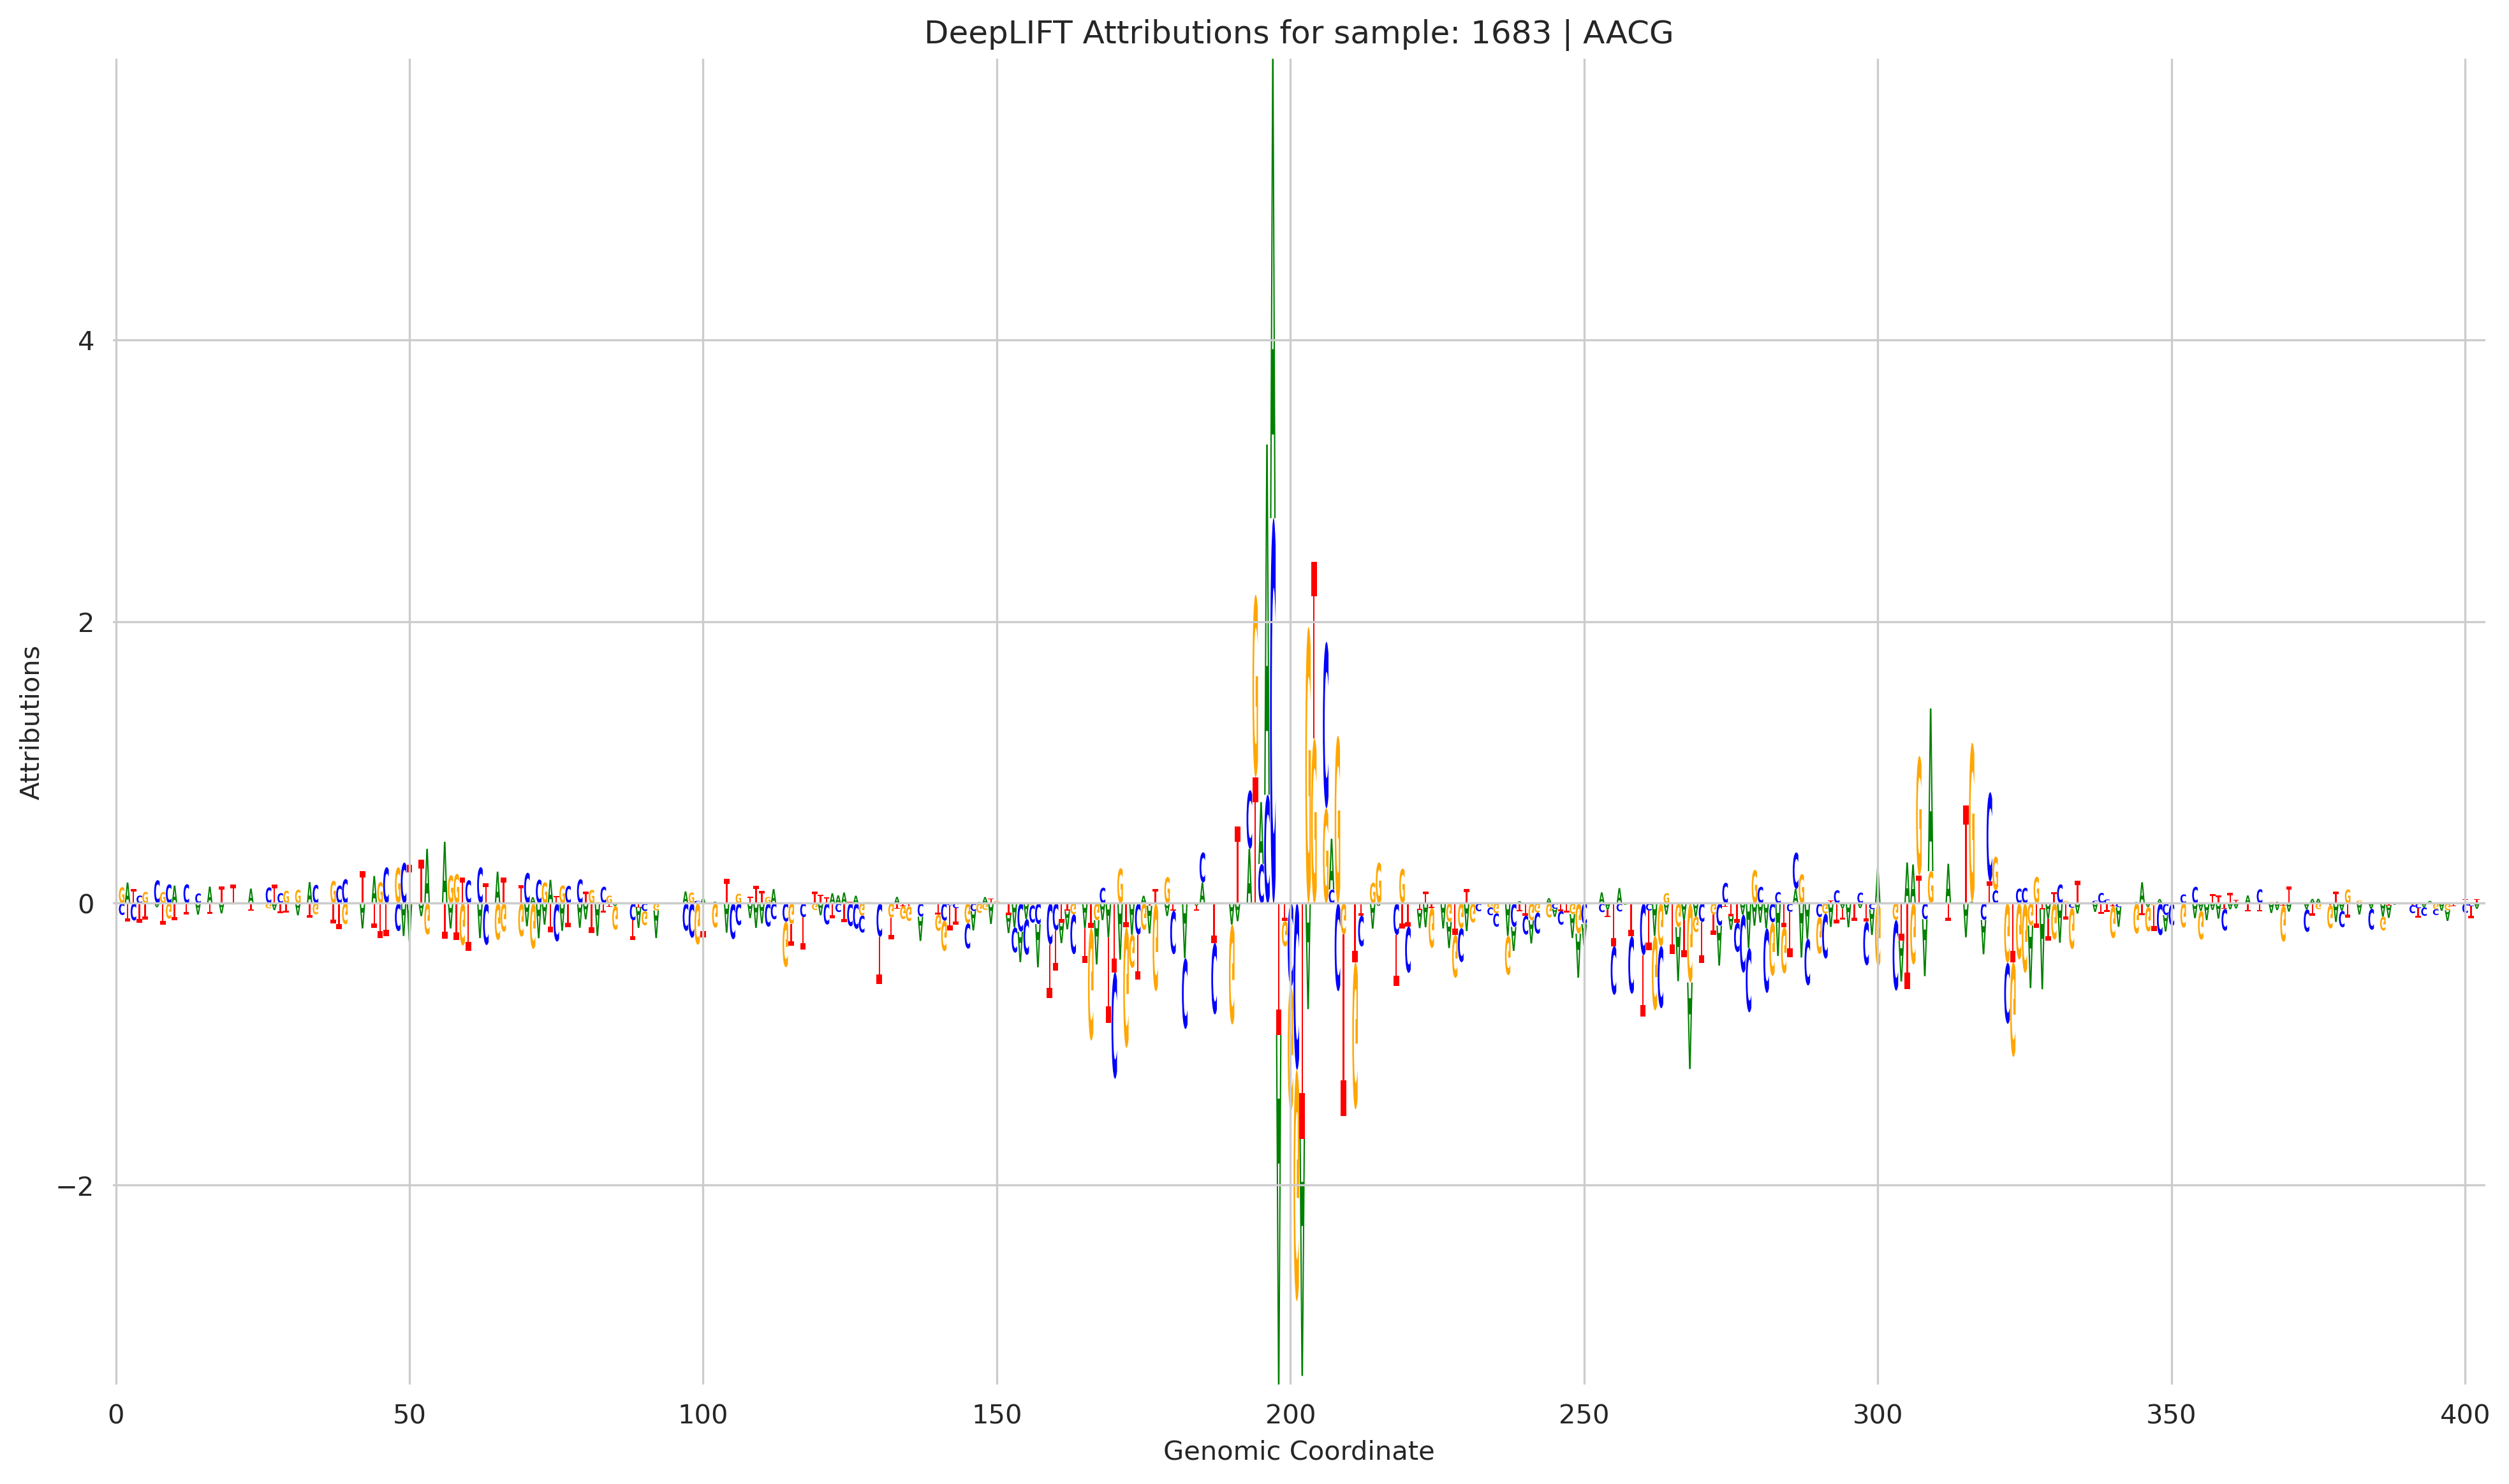

2025-03-19 10:26:31,882 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


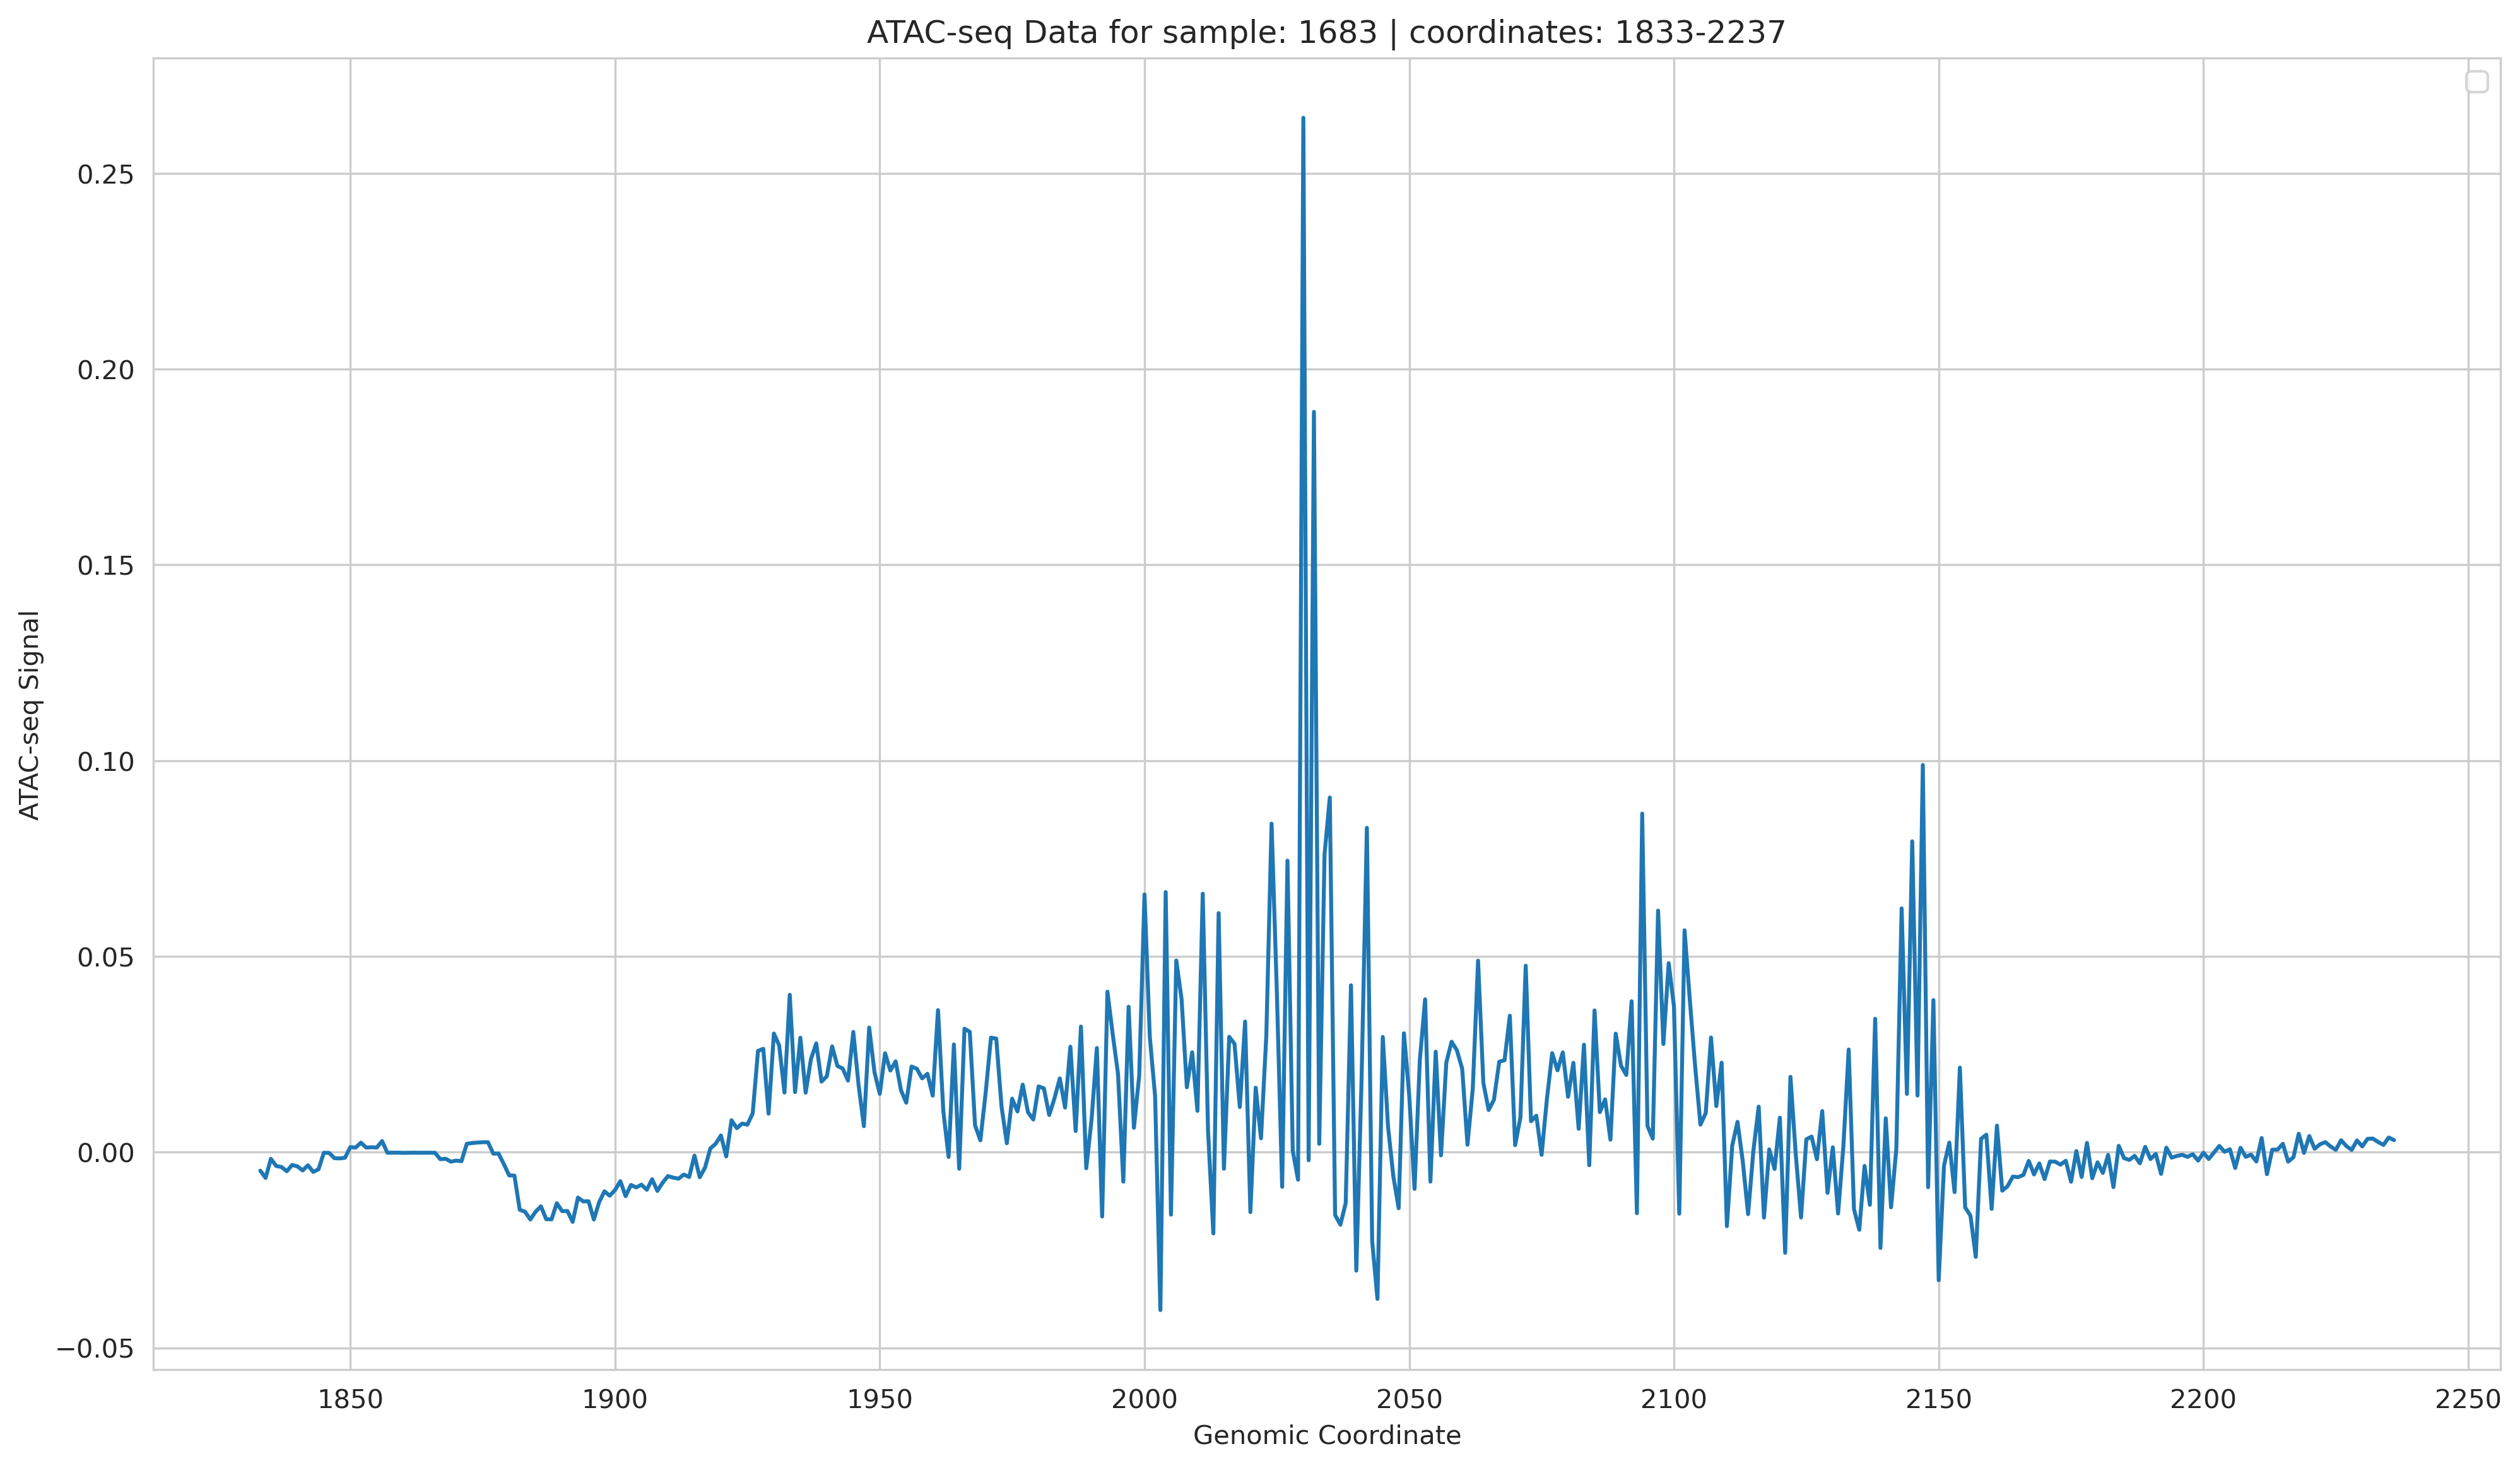

In [8]:
plot_seqlet(seqlets, attrs_list, sample_rank=1341, context_size=200, atac_list=atac_list)

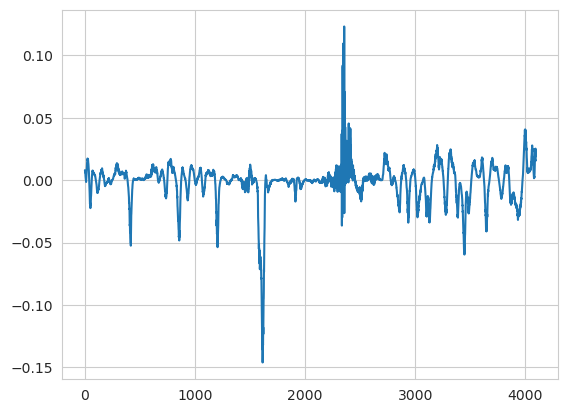

In [ ]:
plt.plot(atac_list[1341])
plt.show()


In [9]:
from dataclasses import dataclass, field
from typing import List, Tuple

@dataclass
class PWM:
    """Container for position weight matrix data."""
    name: str
    matrix: np.ndarray
    bases: List[str] = field(default_factory=lambda: ['A', 'C', 'G', 'T'])
    
    def get_consensus(self, prob_threshold: float = 0.25) -> str:
        """Get consensus sequence from PWM using IUPAC ambiguity codes."""
        iupac_map = {
            'A': 'A', 'C': 'C', 'G': 'G', 'T': 'T',
            'AC': 'M', 'AG': 'R', 'AT': 'W',
            'CG': 'S', 'CT': 'Y', 'GT': 'K',
            'ACG': 'V', 'ACT': 'H', 'AGT': 'D', 'CGT': 'B',
            'ACGT': 'N'
        }
        
        consensus = []
        for pos_probs in self.matrix.T:
            significant_bases = ''.join(b for b, p in zip(self.bases, pos_probs) 
                                     if p >= prob_threshold)
            significant_bases = ''.join(sorted(significant_bases))
            consensus.append(iupac_map.get(significant_bases, 'N'))
        return ''.join(consensus)

def parse_jaspar(jaspar_file: str) -> PWM:
    """Parse a JASPAR format PWM file."""
    with open(jaspar_file) as f:
        lines = f.readlines()
    
    if not lines or len(lines) != 5:
        raise ValueError("Invalid JASPAR format")
        
    name = lines[0].split()[0]
    matrix = []
    
    for line in lines[1:]:
        nums = line.split('[')[1].split(']')[0].strip().split()
        matrix.append([float(x) for x in nums])
    
    matrix = np.array(matrix)
    matrix = matrix / matrix.sum(axis=0)
    
    return PWM(name=name, matrix=matrix)

pwm = parse_jaspar(jaspar_file)
print(f"Loaded PWM: {pwm.name}")
print(f"Consensus sequence: {pwm.get_consensus()}")


Loaded PWM: >MA0148.1
Consensus sequence: TGTTTRCWYWG


In [10]:

def iupac_match(a: str, b: str) -> bool:
    """Check if two IUPAC nucleotide codes match."""
    iupac = {
        'A': {'A'},
        'C': {'C'},
        'G': {'G'},
        'T': {'T'},
        'R': {'A', 'G'},
        'Y': {'C', 'T'},
        'S': {'G', 'C'},
        'W': {'A', 'T'},
        'K': {'G', 'T'},
        'M': {'A', 'C'},
        'B': {'C', 'G', 'T'},
        'D': {'A', 'G', 'T'},
        'H': {'A', 'C', 'T'},
        'V': {'A', 'C', 'G'},
        'N': {'A', 'C', 'G', 'T'}
    }
    
    a = a.upper()
    b = b.upper()
    
    if a not in iupac or b not in iupac:
        raise ValueError(f"Invalid IUPAC code: {a if a not in iupac else b}")
        
    return bool(iupac[a] & iupac[b])


def levenshtein_iupac(seq1: str, seq2: str) -> int:
    """Calculate Levenshtein distance between two DNA sequences with IUPAC codes."""
    if not seq1: return len(seq2)
    if not seq2: return len(seq1)
    
    # Initialize lists instead of range objects
    previous_row = list(range(len(seq2) + 1))
    current_row = [0] * (len(seq2) + 1)
    
    for i, c1 in enumerate(seq1):
        current_row[0] = i + 1
        
        for j, c2 in enumerate(seq2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (not iupac_match(c1, c2))
            
            current_row[j + 1] = min(insertions, deletions, substitutions)
            
        previous_row, current_row = current_row, [0] * (len(seq2) + 1)  # Reset current_row
        
    return previous_row[-1]


def score_seqlet(pwm: PWM, seq: str) -> Tuple[float, int]:
    """Score a sequence against a PWM using IUPAC-aware Levenshtein distance."""
    from Bio import motifs
    from Bio.Seq import Seq
    
    seq_len = len(seq)
    pwm_width = pwm.matrix.shape[1]
    consensus = pwm.get_consensus()
    
    if seq_len < pwm_width:
        max_score = float('-inf')
        best_pos = 0
        for i in range(pwm_width - seq_len + 1):
            cons_slice = consensus[i:i+seq_len]
            raw_dist = levenshtein_iupac(seq, cons_slice)
            norm_score = 1 - (raw_dist / max(len(seq), len(cons_slice)))
            if norm_score > max_score:
                max_score = norm_score
                best_pos = i
        return max_score, best_pos
    
    elif seq_len == pwm_width:
        raw_dist = levenshtein_iupac(seq, consensus)
        norm_score = 1 - (raw_dist / len(consensus))
        return norm_score, 0
    
    else:
        max_score = float('-inf')
        best_pos = 0
        for i in range(seq_len - pwm_width + 1):
            subseq = seq[i:i+pwm_width]
            raw_dist = levenshtein_iupac(subseq, consensus)
            norm_score = 1 - (raw_dist / len(consensus))
            if norm_score > max_score:
                max_score = norm_score
                best_pos = i
        return max_score, best_pos

In [11]:

from tqdm.notebook import tqdm

scores = []
positions = []
for _, row in tqdm(seqlets.iterrows(), total=len(seqlets)):
    score, pos = score_seqlet(pwm, row['sequence'])
    scores.append(score)
    positions.append(pos)

# Add scores to dataframe
seqlets['pwm_score'] = scores
seqlets['pwm_position'] = positions

# Sort by score and display top matches
top_matches = seqlets.sort_values('pwm_score', ascending=False).head(10)
print("\nTop 10 PWM matches:")
print(top_matches[['sequence', 'pwm_score', 'pwm_position']])

  0%|          | 0/112664 [00:00<?, ?it/s]


Top 10 PWM matches:
       sequence  pwm_score  pwm_position
35627      ACAT        1.0             5
112612     ACAC        1.0             5
26       ACATAG        1.0             5
112570     ACTT        1.0             5
42        GCACA        1.0             5
112566     ACAG        1.0             7
112638     ACAC        1.0             5
35539     TGCTC        1.0             4
35528      TCAG        1.0             7
112577     ACAC        1.0             5


In [12]:

def write_fasta(sequences, outfile):
    """Write sequences to FASTA format with auto-generated headers."""
    with open(outfile, 'w') as f:
        for i, seq in enumerate(sequences):
            f.write(f'>seq_{i+1}\n{seq}\n')


def save_seqlets(seqlets, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    pos_seqlets = seqlets[seqlets['attribution'] > 0].reset_index(drop=True)
    neg_seqlets = seqlets[seqlets['attribution'] < 0].reset_index(drop=True)

    pos_seqlets.to_csv(os.path.join(output_dir, "positive_seqlets.csv"), 
                       index=False)
    neg_seqlets.to_csv(os.path.join(output_dir, "negative_seqlets.csv"), 
                       index=False)
    
    candidate_motifs = pos_seqlets['sequence'].tolist()
    write_fasta(
        candidate_motifs, 
        outfile=os.path.join(output_dir, "positive_seqlets.fa")
    )



save_seqlets(seqlets, f"/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/output/{model}_{sample}/")



In [13]:
# run python levenstein.py --jaspar motif.jaspar --seqlets positive_seqlets.csv --output lev_pwm.csv
os.system(f"python /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/levenstein.py --jaspar /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/motifs/{model}.jaspar --seqlets /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/output/{model}_{sample}/positive_seqlets.csv --output /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/output/{model}_{sample}/lev_pwm.csv")

2025-03-12 13:48:36,180 - INFO - Loading PWM from /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/motifs/FOXA1.jaspar
2025-03-12 13:48:36,385 - INFO - Consensus sequence: TGTTTRCWYWG
2025-03-12 13:48:36,385 - INFO - Loading seqlets from /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/output/FOXA1_22Rv1/positive_seqlets.csv
2025-03-12 13:48:36,574 - INFO - Scoring seqlets
100%|██████████| 62295/62295 [00:33<00:00, 1877.17it/s]
2025-03-12 13:49:09,861 - INFO - Saving 62295 matches to /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/output/FOXA1_22Rv1/lev_pwm.csv
2025-03-12 13:49:10,675 - INFO - Summary statistics:
2025-03-12 13:49:10,685 - INFO - Mean score: 0.647
2025-03-12 13:49:10,693 - INFO - Max score: 1.000
2025-03-12 13:49:10,693 - INFO - Number of matches above threshold: 62295


0

In [14]:
min_seqlet = 5
receptor_name = model.split("_")[0]
dir = f"/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/output/{model}_{sample}"
os.system(f"Rscript /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/posthoc.R {min_seqlet} {receptor_name} {dir}")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 62295 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): sequence
dbl (10): example_idx, start, end, attribution, p-value, pwm_score, pwm_posi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 62295 Columns: 8
── Column specification ───────────────────────────────────────────────────────

# A tibble: 15,691 × 2
   sequence     n
   <chr>    <int>
 1 AAAAA      867
 2 AAAAAA     843
 3 AAACA      276
 4 TAAAAAA    255
 5 AAAAAAA    226
 6 TAAAAA     213
 7 TAAAA      211
 8 GTAAAAA    206
 9 GTAAA      196
10 AAAAAC     195
# ℹ 15,681 more rows


Warning message:
Removed 33089 rows containing missing values (`geom_point()`). 
Warning message:
Removed 33089 rows containing missing values (`geom_point()`). 
`geom_smooth()` using formula = 'y ~ x'


Rows: 2,293
Columns: 15
$ example_idx          <dbl> 19296, 5606, 7809, 10815, 15329, 15726, 19368, 13…
$ start                <dbl> 2145, 1645, 2027, 2015, 1881, 1799, 1867, 1840, 1…
$ end                  <dbl> 2154, 1656, 2037, 2027, 1899, 1819, 1891, 1864, 1…
$ attribution.x        <dbl> 76.57542, 55.83527, 55.38211, 53.65329, 52.53322,…
$ `p-value.x`          <dbl> 4.422193e-08, 2.843450e-07, 1.425496e-06, 3.04339…
$ sequence             <chr> "TTTTTAATG", "TTTTAACACCA", "GTAAAAACAA", "CATGAA…
$ pwm_score.x          <dbl> 0.6666667, 0.6363636, 0.6000000, 0.3636364, 0.727…
$ pwm_position.x       <dbl> 0, 0, 1, 0, 6, 4, 2, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0…
$ attribution.y        <dbl> 76.57542, 55.83527, 55.38211, 53.65329, 52.53322,…
$ `p-value.y`          <dbl> 4.422193e-08, 2.843450e-07, 1.425496e-06, 3.04339…
$ pwm_score.y          <dbl> 0.6666667, 0.6363636, 0.6000000, 0.3636364, 0.727…
$ pwm_position.y       <dbl> 0, 0, 1, 0, 6, 4, 2, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0…
$ levenshtein_sc

0

In [16]:
import pandas as pd

# load /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/output/FOXA1_22Rv1/abundant_candidate_motifs.csv
abundant_candidate_motifs = pd.read_csv("/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/output/FOXA1_22Rv1/abundant_candidate_motifs.csv")
abundant_candidate_motifs

,sequence,n
0,AAAAA,867
1,AAAAAA,843
2,AAACA,276
3,TAAAAAA,255
4,AAAAAAA,226
...,...,...
15686,TTTTTTTA,1
15687,TTTTTTTACA,1
15688,TTTTTTTATTTAT,1
15689,TTTTTTTT,1


In [19]:
# drop all sequences with 5 or more As in a row
abundant_candidate_motifs = abundant_candidate_motifs[~abundant_candidate_motifs['sequence'].str.contains('AAAA')]
abundant_candidate_motifs.head(50)



,sequence,n
2,AAACA,276
8,GTAAA,196
13,AAACAA,159
16,TAAACA,153
17,TGTTT,152
18,AAATA,143
19,AACAA,142
20,GTAAACA,141
21,AATAA,137
23,TGTTA,134
